In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# Extract KP and mask

In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import albumentations
import torchvision.transforms as transforms
import torchvision

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
from sparse_feature_pyramid.model import SparseFeaturePyramidAutoencoder
from sparse_feature_pyramid.data import SevenScenesDataModule
from sparse_feature_pyramid.utils import UniversalFactory
from sparse_feature_pyramid.utils.clearml_figure_reporter import ClearmlFigureReporter

factory = UniversalFactory([SparseFeaturePyramidAutoencoder])

In [5]:
model_parameters = AttributeDict(
    name="SparseFeaturePyramidAutoencoder",
    optimizer=AttributeDict(),
    feature_dimensions=[8, 16, 32, 64, 128],
    size_loss_koef=1 / 500000.,
    input_dimension=3,
    kl_loss_coefficient=0.5
)

model = factory.make_from_parameters(model_parameters)
model.set_figure_reporter(ClearmlFigureReporter())

In [6]:
# Тренируем на всех сценах
image_size = 256
data_module_parameters = {
    "batch_size": 16,
    "num_workers": 4,
    "image_size": image_size,
    "scenes": ["fire"], #, "chess", "pumpkin", "stairs", "heads", "office", "redkitchen"],
    "center_crop": True,
    "random_jitter": True,
    "random_rotation": True,
    "root_dataset_path": "/home/andrei/media/7scenes"
}
# task.connect(data_module_parameters)
scene = data_module_parameters["scenes"][0]
data_module = SevenScenesDataModule(**data_module_parameters)

[ToyDataModule] - train subset size 2000
[ToyDataModule] - validation dataset size 2000


In [7]:
%matplotlib inline
batch = None
for x in data_module.test_dataloader():
    batch = x
    break

In [8]:
checkpoint = torch.load("/home/andrei/git/sparse-feature-pyramid/notebook/version_14/checkpoints/epoch=89-step=36629.ckpt")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [9]:
def get_image(batch, index):
    input_image = batch["image"][index].detach().cpu().numpy().transpose(1, 2, 0)
    input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
    input_image = np.clip(input_image, 0, 1)
    return input_image

In [10]:
from PIL import Image

In [11]:
model_mean_std = False

In [12]:
model.eval()
convert_tensor = transforms.ToTensor()
newsize = (256, 256)

orig_image = Image.open('/home/andrei/git/d2-net/hpatches_sequences/hpatches-sequences-release/i_ajuntament/1.ppm')

# reshape image
w, h = orig_image.size
image_to_normalized = np.array(orig_image.resize(newsize)) / 255

# cinvert to proper shape for NN
if model_mean_std:
    mean = data_module._mean
    std = data_module._std
else:
    mean = [image_to_normalized[:, :, channel].mean() for channel in range(image_to_normalized.shape[2])]
    std = [image_to_normalized[:, :, channel].std() for channel in range(image_to_normalized.shape[2])]

image_to_model = (image_to_normalized - np.array(mean))/np.array(std)
image_batch = convert_tensor(image_to_model.astype('float32'))[None]
output = model(image_batch)


output = model(batch["image"])

### Interpolation

In [13]:
from scipy import interpolate
import matplotlib.pyplot as plt

In [16]:
level = 2
prob = output[2][level][0][0].detach().cpu().numpy()#.reshape(-1)

In [19]:
w, h = mask.shape
x = [i for i in range(w)]
y = [i for i in range(h)]
z = prob

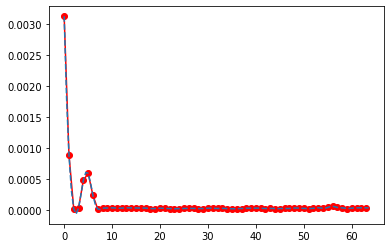

In [70]:
xx, yy = np.meshgrid(x, y)
f = interpolate.interp2d(x, y, z, kind='cubic')
xnew = np.arange(0, w, w/(2*w))
ynew = np.arange(0, w, w/(2*w))
z2 = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, z2[0, :], '--')

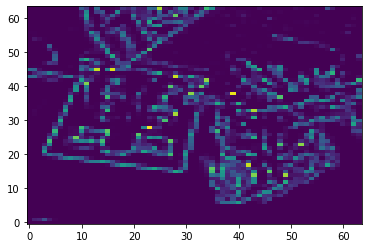

In [71]:
plt.pcolormesh(x,y,z, shading='auto')

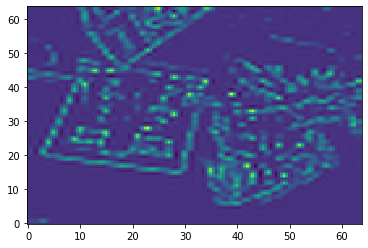

In [106]:
plt.pcolormesh(xnew,ynew, z2, shading='auto')

In [73]:
mask = np.where(z2 > 0.5, 1., 0.)

In [74]:
z2.shape

(128, 128)

In [75]:
z.shape

(64, 64)

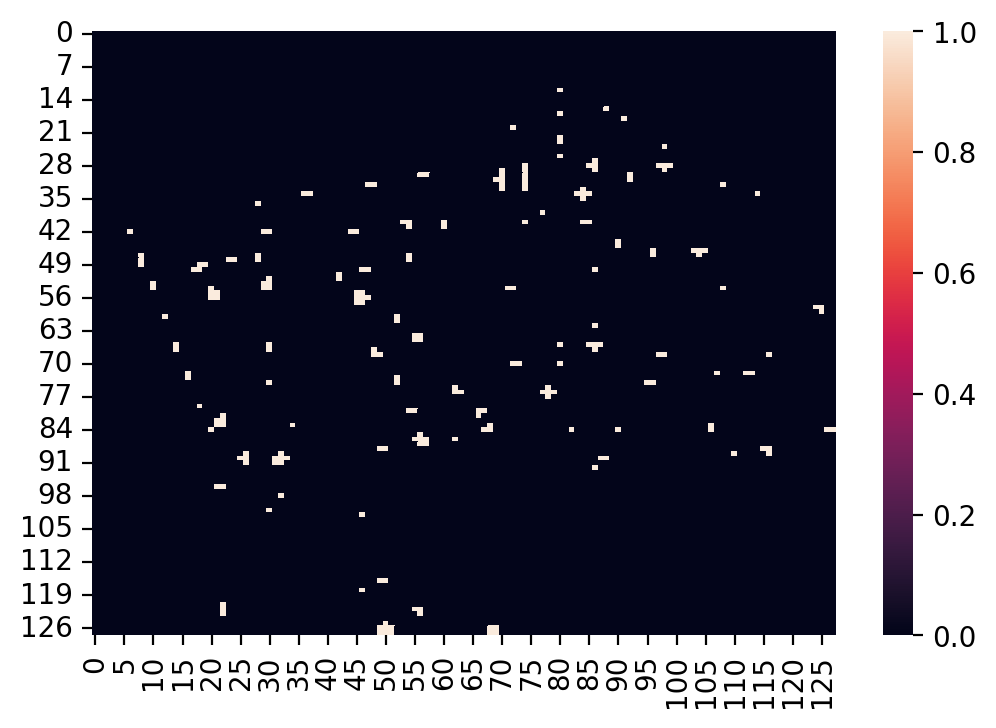

In [90]:
plt.figure(dpi=200)
ax = sns.heatmap(mask)
plt.show()

In [89]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
from matplotlib import cm
im = Image.fromarray(mask).convert('1')
newsize = (64,64)
im2 = np.array(orig_image.resize(newsize))/255
im2.convert('1')

AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [100]:
im2

array([[[0.70980392, 0.70980392, 0.70980392],
        [0.73333333, 0.73333333, 0.73333333],
        [0.63529412, 0.63529412, 0.63529412],
        ...,
        [0.81960784, 0.81960784, 0.81960784],
        [0.82352941, 0.82352941, 0.82352941],
        [0.75294118, 0.75294118, 0.75294118]],

       [[0.71764706, 0.71764706, 0.71764706],
        [0.7254902 , 0.7254902 , 0.7254902 ],
        [0.64313725, 0.64313725, 0.64313725],
        ...,
        [0.57647059, 0.57647059, 0.57647059],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        [0.50588235, 0.50588235, 0.50588235]],

       [[0.57254902, 0.57254902, 0.57254902],
        [0.55294118, 0.55294118, 0.55294118],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        ...,
        [0.49803922, 0.49803922, 0.49803922],
        [0.50980392, 0.50980392, 0.50980392],
        [0.49019608, 0.49019608, 0.49019608]],

       ...,

       [[0.29019608, 0.29019608, 0.29019608],
        [0.29803922, 0.29803922, 0.29803922],
        [0.5372549 , 0

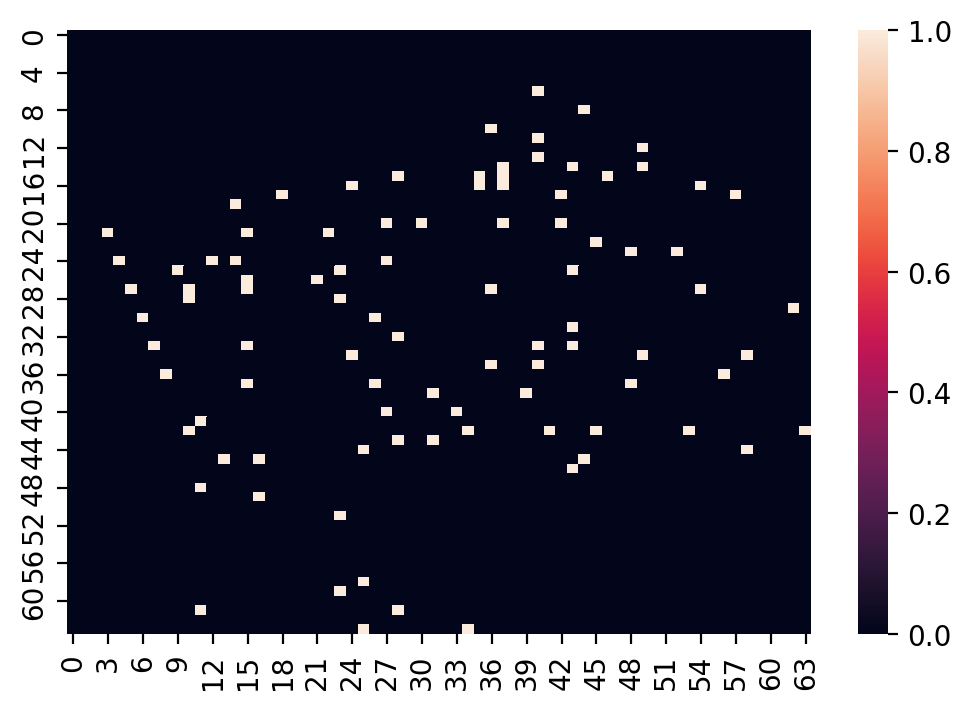

In [15]:
plt.figure(dpi=200)
mask = output[2][level][0][0].detach().cpu().numpy()
ax = sns.heatmap(mask)
plt.show()